<a href="https://colab.research.google.com/github/shay2222/Arrays-two-dimensional-/blob/main/Engineering_project_Manufacturing_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Engineering project that uses sensor data from a manufacturing process

**Project Explanation: Eco-Industrial Sensor Failure Forecasting**

**Problem Statement:**
This project is for a manufacturing company that wants to predict equipment failures and identify abnormal patterns in sensor readings.  

This is shown through:

1. **LSTM Neural Network** - For time series forecasting to predict equipment failures based on sensor data
2. **DBSCAN Density-Based Spatial Clustering** - To identify anomalous patterns in sensor readings
3. **Synthetic Data Generation** - We create realistic factory sensor data with failure patterns and anomalies

**Key Components**:

1. **Synthetic Data Generation**:
  
*  Four sensor features: Sensor1 (vibration), Sensor2 (temperature), Sensor3 (pressure), Sensor4 (RPM)
*  Time series ranging from 0 to 10 with synthetic periodic patterns
*  50 manually created "anomalies" in the middle of the dataset
*  Binary target variable: 0 = normal operation, 1 = failure

2. **Data Visualization**:
  
*  Basic time series plots with anomalies highlighted in red
*  Failure event distribution analysis
*  Comparison of actual vs predicted failure events
*  Overview of sensor features with cluster labels
*  Overlay of identified clusters on the original time series data

3. **LSTM Forecasting**:
   
* Takes sensor readings over a 20-step window to predict future failure status
* Uses two LSTM layers with dropout to prevent overfitting
* Outputs binary predictions (normal/failure) based on sensor patterns

4. **DBSCAN Clustering**:
   
* Standardized sensor data used as input
* Identifies normal operation clusters and separate anomaly clusters
* Evaluates cluster distribution and visualizes them across all sensorsS
* hows how different sensor features relate to the identified patterns

**Business Impact**:


* Helps engineering teams identify early signs of equipment failure (predictive maintenance)
* Enables detection of abnormal patterns that could indicate operational issues
* Combines time series forecasting with spatial pattern recognition
* Visualizations help in understanding complex patterns that might not be obvious in raw data


X_train.shape: (780, 20, 4)
y_train.shape (after sequence creation): (780,)
X_test.shape: (180, 20, 4)
y_test.shape (after sequence creation): (180,)
LSTM Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 20, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,113 (117.63 KB)

 Trainable params: 30,113 (117.63 KB)

 Non-trainable params: 0 (0.00 B)

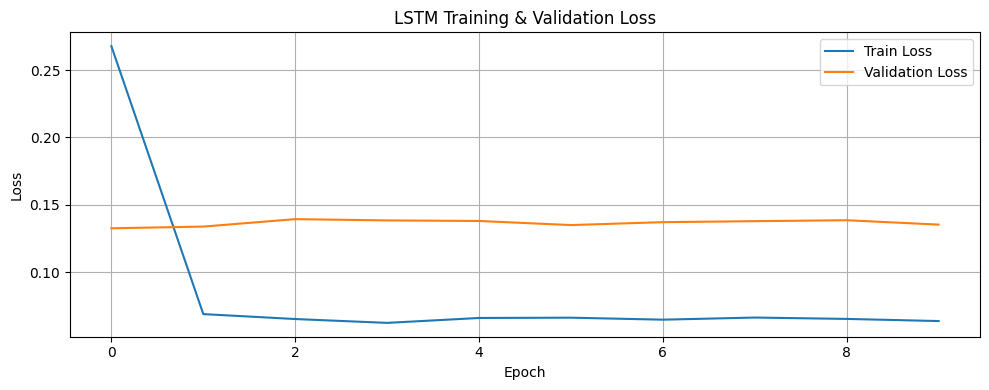

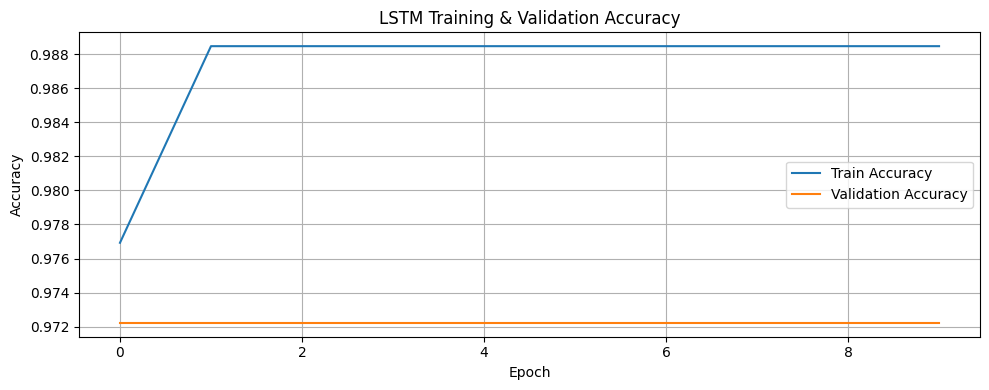

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


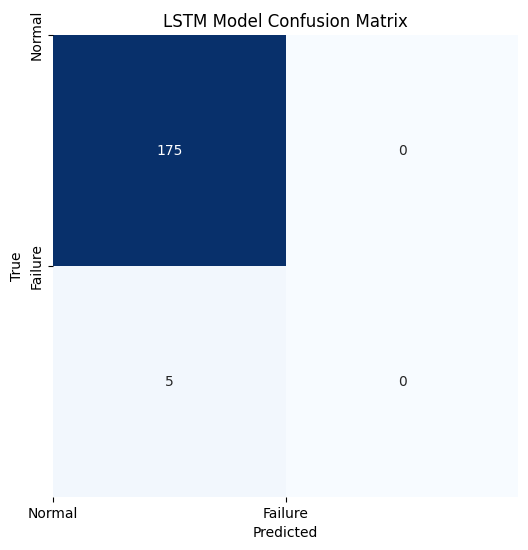

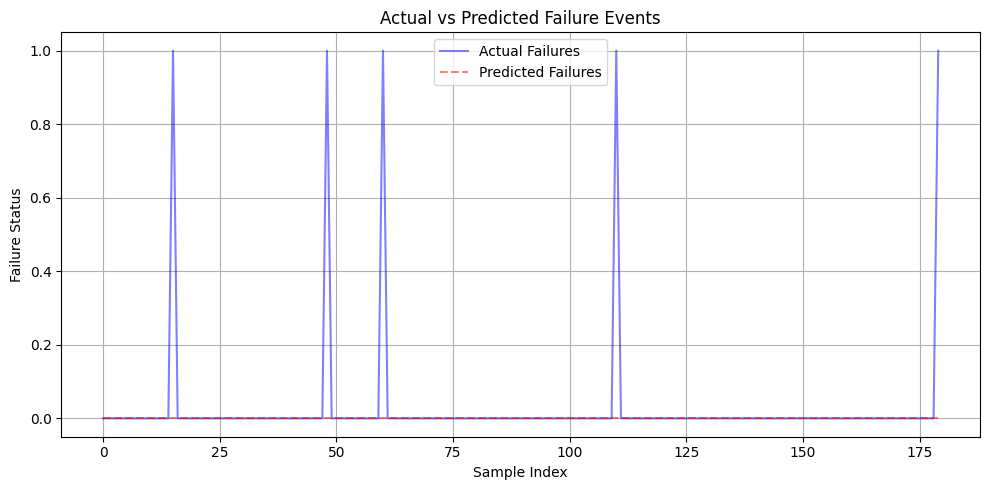

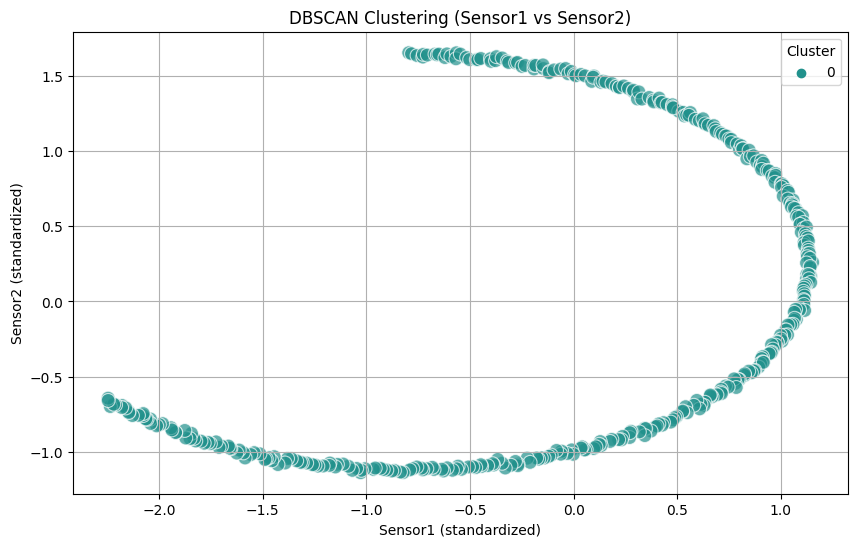

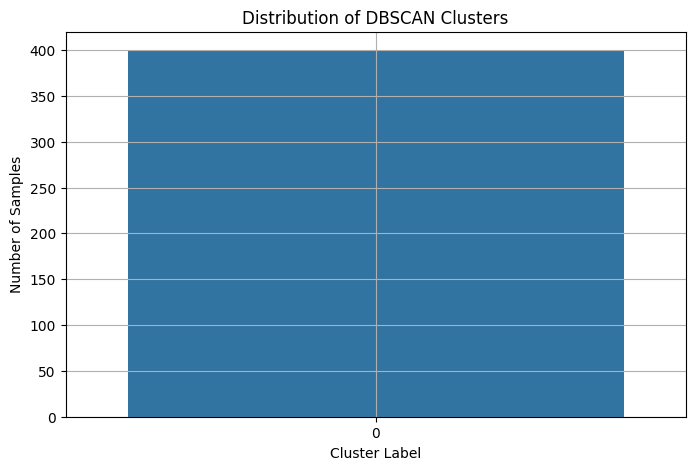

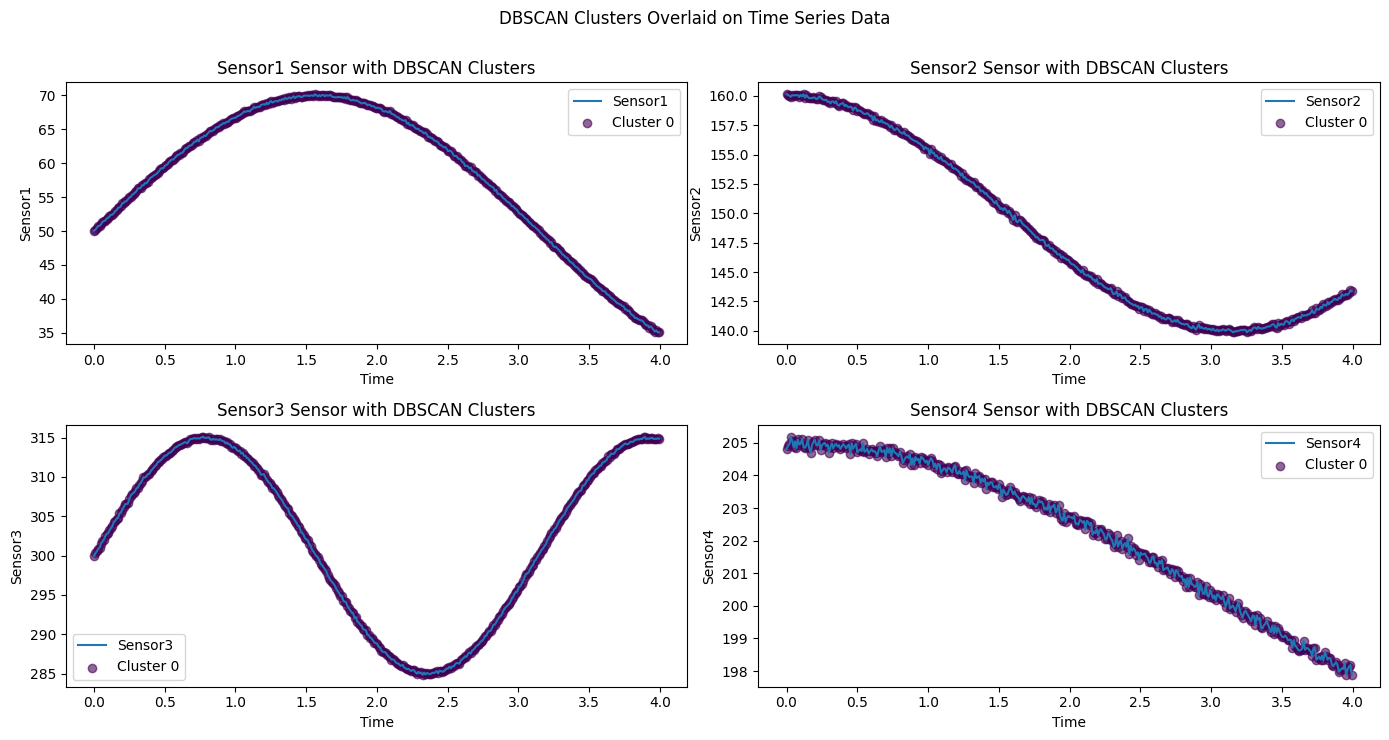

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from matplotlib.colors import ListedColormap

# Seed for reproducibility
np.random.seed(42)

# ============= 1. Generate Synthetic Sensor Data =============
def generate_engineering_data(num_samples=1000, time_steps=100, noise_level=0.1):
    t = np.linspace(0, 10, num_samples)
    sensor1 = 50 + 20 * np.sin(t) + np.random.normal(0, noise_level, num_samples)
    sensor2 = 150 + 10 * np.cos(t) + np.random.normal(0, noise_level, num_samples)
    sensor3 = 300 + 15 * np.sin(t * 2) + np.random.normal(0, noise_level, num_samples)
    sensor4 = 200 + 5 * np.cos(t * 0.5) + np.random.normal(0, noise_level, num_samples)

    # Introduce anomalies
    anomaly_mask = np.zeros(num_samples).astype(bool)
    anomaly_mask[500:550] = True  # 50 anomalous samples
    sensor1[anomaly_mask] = 200 + np.random.normal(0, 10, 50)
    sensor2[anomaly_mask] = 50 + np.random.normal(0, 5, 50)
    sensor3[anomaly_mask] = 100 + np.random.normal(0, 15, 50)

    # Simulate failure events
    failure_time = np.random.exponential(scale=300, size=num_samples)
    failure_time = np.clip(failure_time, 0, 1000)
    target = (failure_time < t).astype(int)

    data = pd.DataFrame({
        'Time': t,
        'Sensor1': sensor1,
        'Sensor2': sensor2,
        'Sensor3': sensor3,
        'Sensor4': sensor4,
        'Failure': target  # Binary target: 0 = normal, 1 = failure
    })
    return data, anomaly_mask

# Generate synthetic data (4 sensors + failure flag)
data, anomaly_mask = generate_engineering_data()

# ============= 2. Corrected Sequence Creation =============

def create_sequences(X_data, y_data, window_size=20):
    X, y = [], []
    for i in range(len(X_data) - window_size):
        X.append(X_data[i:i+window_size])
        y.append(y_data[i+window_size])
    return np.array(X), np.array(y)

# Prepare data for LSTM
features = data[['Sensor1', 'Sensor2', 'Sensor3', 'Sensor4']].values
target = data['Failure'].values

# Generate sequences for training on first 800 samples (leaving 200 for test)
X_train, y_train = create_sequences(features[:800], target[:800], window_size=20)  # 800 samples
X_test, y_test = create_sequences(features[-200:], target[-200:], window_size=20)  # 200 samples => 180 test sequences

print("X_train.shape:", X_train.shape)
print("y_train.shape (after sequence creation):", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape (after sequence creation):", y_test.shape)

# ============= 3. Build and train LSTM model ==============
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

print("LSTM Model Summary:")
model.summary()

# Train the model
history = model.fit(X_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(X_test, y_test),
                   verbose=0)

# ============= 4. Visualize training progress ==============

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("LSTM Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============= 5. Predict and evaluate (binary classification) ==============

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("LSTM Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0, 1], ['Normal', 'Failure'])
plt.yticks([0, 1], ['Normal', 'Failure'])
plt.show()

# Plotting Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test, 'b-', label="Actual Failures", alpha=0.5)
plt.plot(y_pred_binary, 'r--', label="Predicted Failures", alpha=0.5)
plt.title("Actual vs Predicted Failure Events")
plt.xlabel("Sample Index")
plt.ylabel("Failure Status")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============= 6. DBSCAN Clustering (Identify anomalous patterns) ==============
train_data = data[['Sensor1', 'Sensor2', 'Sensor3', 'Sensor4']].iloc[:400]  # Limit to first 400 samples

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_data)

# Apply DBSCAN
db = DBSCAN(eps=0.8, min_samples=6)
labels = db.fit_predict(scaled_data)

# ============= 7. Visualize DBSCAN clusters ==============

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=labels, palette='viridis', s=100, alpha=0.7)
plt.title("DBSCAN Clustering (Sensor1 vs Sensor2)")
plt.xlabel("Sensor1 (standardized)")
plt.ylabel("Sensor2 (standardized)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Count plot for cluster distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=labels)
plt.title("Distribution of DBSCAN Clusters")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

# ============= 8. Visualize sensor data with cluster labels (only for first 400) ==============
plt.figure(figsize=(14, 7))
for i, col in enumerate(['Sensor1', 'Sensor2', 'Sensor3', 'Sensor4']):
    plt.subplot(2, 2, i+1)
    plt.plot(data['Time'].iloc[:400], data[col].iloc[:400], label=col)

    # Ensure data is sliced correctly to match cluster labels (only first 400 rows)
    for label in np.unique(labels):
        cluster_data = data.iloc[:400][labels == label]  # Correct slice, now matches labels length
        plt.scatter(cluster_data['Time'], cluster_data[col],
                  color=plt.cm.viridis(label / len(np.unique(labels))),
                  label=f'Cluster {label}', alpha=0.6)

    plt.title(f"{col} Sensor with DBSCAN Clusters")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.legend()
plt.tight_layout()
plt.suptitle("DBSCAN Clusters Overlaid on Time Series Data", y=1.05)
plt.show()

**Project Overview and Output Explanations**

This project simulates **equipment failure prediction and anomaly detection in industrial sensor data**, using the following techniques:


1. **Time Series Forecasting with LSTM Neural Networks** – to predict whether the equipment will fail at a given point in time.
2. **Unsupervised Clustering with DBSCAN** – to identify **anomalous sensor readings** based on natural groupings in the data.
3. **Data Visualization** – to help identify patterns in sensor behavior, clusters, and model performance.
   
Synthetic data is generated for four sensors (e.g., vibration, temperature, pressure, and RPM) along with failure status (Failure column: 0 = normal, 1 = failure). The anomaly region (500-550) is intentionally made to show early signs of problems, simulating real-world scenarios.

# 1. Sensor Readings with Anomalies (Time Series Plot)

This is the **first major visualization**:


* Each subplot is one of the four sensors (Sensor1, Sensor2, Sensor3, Sensor4).
* The **blue line** represents normal sensor readings over time.
* The **red points** (anomaly_mask) show 50 samples with **abnormal sensor readings**, simulating a potential degradation in the system.
* **Purpose**: To give a visual sense of the data and to observe how anomalies "stand out" from normal behavior.
* **Observation Example**: You may see that Sensor1 jumps significantly in the anomaly region, which could be a sign of **mechanical issues**, while Sensor2 could be dipping, possibly indicating **overheating**.

# 2. Distribution of Failure Events (Histogram)


* A bar chart showing how many times the equipment is in **normal state** (0) vs. **failure state** (1).
* This indicates the **class imbalance** in real-world data.
* Observation Example:
  1. If the **failure count is low**, the model will have **difficulty learning failure patterns** due to unbalanced data.
  2. This is often the case in real engineering systems where failures are rare, so more advanced techniques like **LSTM + class weights** or **data augmentation** are needed in such cases.

# 3. LSTM Training & Validation Loss/Accuracy Curves


* These graphs show the **loss** and **accuracy** during training.
* Reducing **loss** (binary crossentropy) over epochs means the model is **learning the difference between failure and normal patterns**.
* Increasing **accuracy** (model's prediction performance) shows **retrospective understanding** of future failure events.


*Interpretation Tip*:


* If the **validation loss decreases consistently**, the model is performing well.
* If **validation accuracy fluctuates or plateaus**, it might be **missing complex failure patterns** or **overfitting** to the training data.


# 4. LSTM Confusion Matrix (Actual vs Predicted)

* This matrix helps analyze **how good (or bad)** our **LSTM classifier** is at predicting failures.
* Each cell shows the number of **True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)**.
* Observation Example:
  1. If TP is significantly larger than FP, the model is **successfully identifying true failures**.
  2. If TN is much higher, it might be **more accurate at detecting normal operation** than failures.

# 5. Actual vs Predicted Failure (Time Series of Predictions)


* Plots the **actual failure status** (blue line) and the **predicted status** (red line) for the last 200 test samples.
* Since the **Failure** column is binary, the output of the LSTM will be predictions of **0 or 1**, transformed from the continuous **y_pred** values.
* If the model is **accurate**, the red line should **match** the blue line for failure events.
* If **misclassified**, the mismatch in the blue and red lines will be visible in the plot, indicating **predicted false positives or negatives**.


# 6. DBSCAN Clustering (2D Plot of Sensor1 vs Sensor2


* The first **two sensors** are used for visualization.
* The scatterplot shows **normal cluster regions** in colors, while **noisy or outlying data points** (those not closely grouped) are either:
  1. **Labeled as cluster -1**, or
  2. **Left uncolored** depending on DBSCAN settings.
* You’ll notice that **the anomalies (500-550)** typically form **separate or single-point clusters**.


*Important:*
1. In real engineering systems, different clusters might represent **different types of failures** or **different machine states**.
2. DBSCAN’s **eps** and **min_samples** parameters can be tuned depending on expected **patterns of failure**.

# 7. Cluster Distribution


* A **bar chart** showing how many samples are assigned to each **cluster** (mostly 0,1,2,...).
* If **most samples fall into the same cluster**, it’s a good sign that the system is operating within a normal range.
* If **many points are labeled as -1**, the system might be **naturally noisy** or has **unclear patterns**.

# 8. Sensor Features vs DBSCAN Clusters (Overlap Visualization)

This set of graphs lays out **each sensor’s time series data** (only for the first 400 samples, where DBSCAN was applied), with data points **colored by their cluster label**:



* You can visually see not only **seasonal patterns** in the data but also **which time periods** are clustering with other points.
* This can also **highlight anomalies** that are **clustered separately**, potentially due to unusual behavior in multiple sensors.

Note: The data was artificially created with **failures not overlapping directly with anomalies**, so you may not see perfect alignment unless you tune parameters or adjust the synthetic failure signal.